In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from sklearn.cluster import KMeans
import random
from torch.serialization import add_safe_globals

In [2]:
def fix_seeds(seed=42, deterministic=True):
    """
    Fix all random seeds for reproducibility.

    Args:
        seed (int): The seed value to use.
        deterministic (bool): If True, forces deterministic behavior in cuDNN (may reduce performance).
    """
    # Python's built-in random module
    random.seed(seed)

    # NumPy random generator
    np.random.seed(seed)

    # PyTorch seed for CPU & CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU

    # Ensuring deterministic behavior (if desired)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False  # Might slow down training but ensures reproducibility
fix_seeds()

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
class KmeanPINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, convection_velocity=1.0):
        """
        Initialize the Residual-RAE PINN model.
        
        Args:
            input_dim: Dimension of input (typically 1 for 1D convection PDE - time and space)
            output_dim: Dimension of output (typically 1 for scalar solution u)
            hidden_dim: Number of neurons in each hidden layer
            num_layers: Number of hidden layers
        """
        super(KmeanPINN, self).__init__()
        
        # Store parameters
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.convection_velocity = convection_velocity
        
        # Build the neural network
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        """Forward pass of the neural network"""
        return self.network(x)
    
    def compute_pde_residual(self, x, t):
        """
        Compute the residual of the 1D convection PDE: du/dt + a * du/dx = 0
        
        Args:
            x: Spatial coordinates
            t: Time coordinates
            
        Returns:
            PDE residual at points (x,t)
        """
        # Create input tensor
        inputs = torch.cat([x, t], dim=1)
        inputs.requires_grad = True
        
        # Forward pass to get u(x,t)
        u = self(inputs)
        
        grad_u = torch.autograd.grad(
            u,
            inputs,
            grad_outputs=torch.ones_like(u),
            create_graph=True
        )[0]
        u_x = grad_u[:, 0:1]  # derivative with respect to x
        u_t = grad_u[:, 1:2]
        
        # Compute PDE residual: du/dt + a * du/dx = 0
        residual = u_t + self.convection_velocity * u_x
        
        return residual
    
    def compute_ic_residual(self, x, t, u_ic):
        """
        Compute the residual of the initial condition: u(x,0) = u_ic(x)
        
        Args:
            x: Spatial coordinates at t=0
            t: Time coordinates (should be zeros)
            u_ic: Initial condition function
            
        Returns:
            Initial condition residual
        """
        inputs = torch.cat([x, t], dim=1)
        u_pred = self(inputs)
        u_actual = u_ic(x)
        residual = u_pred - u_actual
        return residual
    
    def compute_periodic_bc_residual(self, x_left, x_right, t_bc):
        """
        Compute the residual of the periodic boundary condition: u(x_min, t) = u(x_max, t)
        
        Args:
            x_left: Left boundary spatial coordinates
            x_right: Right boundary spatial coordinates
            t_bc: Time coordinates for boundary points
            
        Returns:
            Periodic boundary condition residual
        """
        # Create input tensors for left and right boundaries
        inputs_left = torch.cat([x_left, t_bc], dim=1)
        inputs_right = torch.cat([x_right, t_bc], dim=1)
        
        # Forward pass to get u at both boundaries
        u_left = self(inputs_left)
        u_right = self(inputs_right)
        
        # Compute residual: u(x_min, t) - u(x_max, t)
        residual = u_left - u_right
        
        return residual

In [5]:
class KMeansPINNSolver:
    def __init__(self, model, n_clusters_r, n_clusters_bc, n_clusters_ic,
        gamma_r=1.0, gamma_bc=1.0, gamma_ic=1.0,
        learning_rate=0.001, beta=0.9, random_state=None,
        w_mean=0.9, w_var=0.4, w_max=0.1):
        """
        Initialize the KMeans-weighted PINN solver.

        Args:
            model: The PINN model (...)
            n_clusters_r: Number of clusters for residual points.
            n_clusters_bc: Number of clusters for boundary condition points.
            n_clusters_ic: Number of clusters for initial condition points.
            gamma_r: Penalty coefficient for residual term.
            gamma_bc: Penalty coefficient for boundary condition term.
            gamma_ic: Penalty coefficient for initial condition term.
            learning_rate: Learning rate for the optimizer.
            beta: Momentum factor for updating cluster weights (0 <= beta < 1).
            random_state: Random state for KMeans for reproducibility.
            w_mean: Weight factor for the mean absolute residual component
            w_var: Weight factor for the variance of absolute residual component
            w_max: Weight factor for the max absolute residual component
        """
        self.model = model.to(device)
        self.n_clusters_r = n_clusters_r
        self.n_clusters_bc = n_clusters_bc
        self.n_clusters_ic = n_clusters_ic
        self.gamma_r = gamma_r
        self.gamma_bc = gamma_bc
        self.gamma_ic = gamma_ic
        self.learning_rate = learning_rate
        self.beta = beta
        self.random_state = random_state
        # Store the statistic weights
        self.w_mean = w_mean
        self.w_var = w_var
        self.w_max = w_max

        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        self.cluster_weights_r = None
        self.cluster_weights_bc = None
        self.cluster_weights_ic = None

        self.labels_r = None
        self.labels_bc = None
        self.labels_ic = None

        # Ensure weights are non-negative
        if not (self.w_mean >= 0 and self.w_var >= 0 and self.w_max >= 0):
            raise ValueError("Statistic weights (w_mean, w_var, w_max) must be non-negative.")
        if self.w_mean + self.w_var + self.w_max <= 0:
             print("Warning: All statistic weights (w_mean, w_var, w_max) are zero. Effective weights will be uniform.")

    def _cluster_points(self, x_r, t_r, t_bc, x_ic, t_ic):
        """Performs KMeans clustering on the input points."""
        # Residual points clustering (spatial + temporal)
        if self.n_clusters_r > 0 and x_r.numel() > 0:
            X_r_np = torch.cat([x_r, t_r], dim=1).detach().cpu().numpy()
            if X_r_np.shape[0] >= self.n_clusters_r:
                kmeans_r = KMeans(n_clusters=self.n_clusters_r, random_state=self.random_state, n_init=10)
                self.labels_r = torch.from_numpy(kmeans_r.fit_predict(X_r_np)).long().to(device)
                self.cluster_weights_r = torch.ones(self.n_clusters_r, device=device) / self.n_clusters_r
            else:
                print(f"Warning: Not enough residual points ({X_r_np.shape[0]}) for {self.n_clusters_r} clusters. Skipping residual clustering.")
                self.n_clusters_r = 0 # Disable clustering for this part

        # Boundary points clustering (temporal only for periodic BC)
        if self.n_clusters_bc > 0 and t_bc.numel() > 0:
            X_bc_np = t_bc.detach().cpu().numpy() # Assuming t_bc determines BC clusters
            if X_bc_np.shape[0] >= self.n_clusters_bc:
                kmeans_bc = KMeans(n_clusters=self.n_clusters_bc, random_state=self.random_state, n_init=10)
                self.labels_bc = torch.from_numpy(kmeans_bc.fit_predict(X_bc_np)).long().to(device)
                self.cluster_weights_bc = torch.ones(self.n_clusters_bc, device=device) / self.n_clusters_bc
            else:
                 print(f"Warning: Not enough BC points ({X_bc_np.shape[0]}) for {self.n_clusters_bc} clusters. Skipping BC clustering.")
                 self.n_clusters_bc = 0 # Disable clustering for this part

        # Initial condition points clustering (spatial + temporal, though t=0)
        if self.n_clusters_ic > 0 and x_ic.numel() > 0:
            X_ic_np = torch.cat([x_ic, t_ic], dim=1).detach().cpu().numpy()
            if X_ic_np.shape[0] >= self.n_clusters_ic:
                kmeans_ic = KMeans(n_clusters=self.n_clusters_ic, random_state=self.random_state, n_init=10)
                self.labels_ic = torch.from_numpy(kmeans_ic.fit_predict(X_ic_np)).long().to(device)
                self.cluster_weights_ic = torch.ones(self.n_clusters_ic, device=device) / self.n_clusters_ic
            else:
                print(f"Warning: Not enough IC points ({X_ic_np.shape[0]}) for {self.n_clusters_ic} clusters. Skipping IC clustering.")
                self.n_clusters_ic = 0 # Disable clustering for this part


    # In class KMeansPINNSolver:

    def _compute_and_update_weights(self, R_r, R_bc, R_ic):
        """
        Computes new cluster weights based on mean, variance, and max
        residuals, normalizes them, and updates using momentum.
        """
        epsilon = 1e-10

        def calculate_combined_weights(n_clusters, labels, R_abs):
            if n_clusters <= 0 or labels is None or R_abs.numel() == 0:
                return None

            means = torch.zeros(n_clusters, device=device)
            variances = torch.zeros(n_clusters, device=device)
            maxima = torch.zeros(n_clusters, device=device)

            for k in range(n_clusters):
                cluster_indices = torch.where(labels == k)[0]
                if len(cluster_indices) > 0:
                    cluster_residuals_abs = R_abs[cluster_indices].detach()
                    means[k] = torch.mean(cluster_residuals_abs)
                    maxima[k] = torch.max(cluster_residuals_abs)
                    # Calculate variance, handle single-point clusters
                    if len(cluster_indices) > 1:
                       variances[k] = torch.var(cluster_residuals_abs, unbiased=False) # Population variance
                    else:
                       variances[k] = 0.0 # Variance is 0 for a single point
                # else: means, variances, maxima remain 0 for empty clusters

            # Normalize each statistic across clusters (sum normalization)
            norm_means = means / (means.sum() + epsilon)
            norm_variances = variances / (variances.sum() + epsilon) # Normalize even if some are 0
            norm_maxima = maxima / (maxima.sum() + epsilon)

            # Combine statistics using weights
            combined_weights = (self.w_mean * norm_means +
                                self.w_var * norm_variances +
                                self.w_max * norm_maxima)

            # Final normalization of combined weights (sum to 1)
            total_combined_weight = combined_weights.sum() + epsilon
            final_weights = combined_weights / total_combined_weight

            return final_weights

        if self.n_clusters_r > 0:
            new_weights_r = calculate_combined_weights(self.n_clusters_r, self.labels_r, torch.abs(R_r))
            if new_weights_r is not None:
                 self.cluster_weights_r = self.beta * new_weights_r + (1 - self.beta) * self.cluster_weights_r

        if self.n_clusters_bc > 0:
            new_weights_bc = calculate_combined_weights(self.n_clusters_bc, self.labels_bc, torch.abs(R_bc))
            if new_weights_bc is not None:
                 self.cluster_weights_bc = self.beta * new_weights_bc + (1 - self.beta) * self.cluster_weights_bc

        if self.n_clusters_ic > 0:
            new_weights_ic = calculate_combined_weights(self.n_clusters_ic, self.labels_ic, torch.abs(R_ic))
            if new_weights_ic is not None:
                self.cluster_weights_ic = self.beta * new_weights_ic + (1 - self.beta) * self.cluster_weights_ic

    def _compute_loss(self, R_r, R_bc, R_ic):
        """Computes the total weighted loss."""
        loss_r = torch.tensor(0.0, device=device)
        if self.n_clusters_r > 0 and self.labels_r is not None:
            point_weights_r = self.cluster_weights_r[self.labels_r]
            loss_r = (point_weights_r * (R_r**2)).sum()
        elif R_r.numel() > 0: # Fallback to uniform weighting if clustering disabled/failed
            loss_r = torch.mean(R_r**2) * R_r.numel() # Keep scale similar

        loss_bc = torch.tensor(0.0, device=device)
        if self.n_clusters_bc > 0 and self.labels_bc is not None:
            point_weights_bc = self.cluster_weights_bc[self.labels_bc]
            loss_bc = (point_weights_bc * (R_bc**2)).sum()
        elif R_bc.numel() > 0:
            loss_bc = torch.mean(R_bc**2) * R_bc.numel()

        loss_ic = torch.tensor(0.0, device=device)
        if self.n_clusters_ic > 0 and self.labels_ic is not None:
            point_weights_ic = self.cluster_weights_ic[self.labels_ic]
            loss_ic = (point_weights_ic * (R_ic**2)).sum()
        elif R_ic.numel() > 0:
            loss_ic = torch.mean(R_ic**2) * R_ic.numel()

        loss = self.gamma_r * loss_r + self.gamma_bc * loss_bc + self.gamma_ic * loss_ic
        return loss, loss_r, loss_bc, loss_ic


    def train(self, x_r, t_r, x_bc_left, x_bc_right, t_bc, x_ic, t_ic, u_ic_fn, epochs=10000,verbose=True):
        """
        Train the KMeans-PINN model with periodic boundary conditions.

        Args:
            x_r, t_r: PDE residual points (tensors on the correct device).
            x_bc_left: Left boundary spatial coordinates (tensor).
            x_bc_right: Right boundary spatial coordinates (tensor).
            t_bc: Time coordinates for boundary points (tensor).
            x_ic, t_ic: Initial condition points (tensors).
            u_ic_fn: Initial condition function (callable).
            epochs: Number of training epochs.
            verbose: Whether to print training progress.

        Returns:
            Trained model and final loss value.
        """
        # Ensure input tensors are on the correct device
        x_r, t_r = x_r.to(device), t_r.to(device)
        x_bc_left, x_bc_right = x_bc_left.to(device), x_bc_right.to(device)
        t_bc = t_bc.to(device)
        x_ic, t_ic = x_ic.to(device), t_ic.to(device)

        # Perform clustering once before training starts
        self._cluster_points(x_r, t_r, t_bc, x_ic, t_ic)

        for epoch in tqdm(range(epochs)):
            self.model.train()

            R_r = self.model.compute_pde_residual(x_r, t_r)
            R_bc = self.model.compute_periodic_bc_residual(x_bc_left, x_bc_right, t_bc)
            R_ic = self.model.compute_ic_residual(x_ic, t_ic, u_ic_fn)

            # Compute cluster weights based on current residuals and update with momentum
            self._compute_and_update_weights(R_r, R_bc, R_ic)

            # Compute the weighted loss
            loss, loss_r_val, loss_bc_val, loss_ic_val = self._compute_loss(R_r, R_bc, R_ic)

            # Backward pass and optimization
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Print progress
            if verbose and epoch % (epochs // 10 if epochs >= 10 else 1) == 0:
                 print(f"Epoch {epoch}: Loss = {loss.item():.6f}, "
                       f"PDE Loss = {loss_r_val.item():.6f}, "
                       f"BC Loss = {loss_bc_val.item():.6f}, "
                       f"IC Loss = {loss_ic_val.item():.6f}")

        self.model.eval()
        return self.model, loss.item()

In [6]:
# Define PDE domain
x_min, x_max = 0.0, 2*np.pi
t_min, t_max = 0.0, 1.0

# Generate training points
n_x, n_t = 50, 50
n_ic = 512
n_bc = 256

x_r = torch.linspace(x_min, x_max, n_x).repeat(n_t, 1).t().reshape(-1, 1).to(device)
t_r = torch.linspace(t_min, t_max, n_t).repeat(n_x).reshape(-1, 1).to(device)

x_ic = torch.linspace(x_min, x_max, n_ic).reshape(-1, 1).to(device)
t_ic = torch.zeros(n_ic, 1).to(device)

x_bc_left = torch.full((n_bc, 1), x_min).to(device)
x_bc_right = torch.full((n_bc, 1), x_max).to(device)
t_bc = torch.linspace(t_min, t_max, n_bc).reshape(-1, 1).to(device)

def u_ic_fn(x):
    return torch.sin(x)

# Create model and solver
input_dim = 2  # (x, t)
output_dim = 1  # u(x,t)
hidden_dim = 50
num_layers = 4
convection_velocity = 70.0

# Hyperparameters from the algorithm
n_clusters_r = 100      # k nearest neighbors for residual points
n_clusters_bc = 10     # k nearest neighbors for boundary points
n_clusters_ic = 20     # k nearest neighbors for initial condition points
gamma_r = 1.0   # penalty coefficient for residual
gamma_bc = 40.0  # penalty coefficient for boundary
gamma_ic = 10.0  # penalty coefficient for initial condition
learning_rate = 1e-3

# Initialize model and solver
model = KmeanPINN(input_dim,output_dim,hidden_dim,num_layers,convection_velocity).to(device)
solver = KMeansPINNSolver(model,n_clusters_r,n_clusters_bc,n_clusters_ic,gamma_r, gamma_bc, gamma_ic, learning_rate)

In [7]:
model,final_loss = solver.train(
    x_r, t_r, 
    x_bc_left, x_bc_right, t_bc, 
    x_ic, t_ic, 
    u_ic_fn, 
    epochs=100000
)

print(f"Training complete. Final loss: {final_loss:.6f}")

  0%|          | 0/100000 [00:00<?, ?it/s]/home/vyom/Desktop/MLNS/env/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 7/100000 [00:00<1:00:03, 27.75it/s]

Epoch 0: Loss = 135679.312500, PDE Loss = 65823.132812, BC Loss = 29.878788, IC Loss = 6866.102539


 10%|█         | 10011/100000 [02:47<24:54, 60.20it/s]

Epoch 10000: Loss = 2852.237305, PDE Loss = 96.895187, BC Loss = 65.110275, IC Loss = 15.093096


 20%|██        | 20008/100000 [05:34<21:44, 61.30it/s]

Epoch 20000: Loss = 2226.879639, PDE Loss = 75.623940, BC Loss = 51.532459, IC Loss = 8.995728


 30%|███       | 30010/100000 [08:19<18:59, 61.40it/s]

Epoch 30000: Loss = 1937.343506, PDE Loss = 62.002838, BC Loss = 45.023140, IC Loss = 7.441514


 40%|████      | 40007/100000 [11:05<16:21, 61.14it/s]

Epoch 40000: Loss = 1616.931152, PDE Loss = 50.936310, BC Loss = 37.686695, IC Loss = 5.852704


 50%|█████     | 50011/100000 [13:50<13:40, 60.91it/s]

Epoch 50000: Loss = 1430.968506, PDE Loss = 50.260117, BC Loss = 33.479908, IC Loss = 4.151213


 60%|██████    | 60011/100000 [16:35<11:06, 60.03it/s]

Epoch 60000: Loss = 1291.858276, PDE Loss = 41.514416, BC Loss = 30.425110, IC Loss = 3.333953


 70%|███████   | 70013/100000 [19:20<08:17, 60.29it/s]

Epoch 70000: Loss = 1195.522949, PDE Loss = 38.753529, BC Loss = 28.153782, IC Loss = 3.061811


 80%|████████  | 80012/100000 [22:06<05:39, 58.92it/s]

Epoch 80000: Loss = 1092.698853, PDE Loss = 37.201313, BC Loss = 25.736158, IC Loss = 2.605133


 90%|█████████ | 90008/100000 [24:51<02:57, 56.40it/s]

Epoch 90000: Loss = 1070.417236, PDE Loss = 55.516716, BC Loss = 24.699593, IC Loss = 2.691687


100%|██████████| 100000/100000 [27:35<00:00, 60.39it/s]

Training complete. Final loss: 435.674377


In [9]:
def exact_solution_fft(x_array, t, h_values, beta, x_max):
    """
    Computes the exact solution of the 1D convection PDE using the Fourier transform approach.
    Assumes periodic boundary conditions on [0, x_max).

    Args:
        x_array (np.ndarray): 1D array of x-values (length N) on [0, x_max), evenly spaced.
        t (float): Time at which to evaluate the solution.
        h_values (np.ndarray): 1D array of h(x_array), same length as x_array.
        beta (float): Convection speed.
        x_max (float): Domain length for periodic boundary conditions.

    Returns:
        np.ndarray: Real part of the exact solution u(x, t) on the same grid x_array.
    """
    N = len(x_array)
    # Forward FFT of initial condition
    H_k = np.fft.fft(h_values)
    # Wavenumbers k: 2π * (integer) / x_max
    k_array = 2 * np.pi * np.fft.fftfreq(N, d=(x_max / N))
    # Multiply by e^{- i * beta * k * t}
    phase_factor = np.exp(-1j * beta * k_array * t)
    U_k = H_k * phase_factor
    # Inverse FFT to get solution
    u_vals = np.fft.ifft(U_k)
    return u_vals.real

In [10]:
add_safe_globals([KmeanPINN])

In [11]:
model.eval()

KmeanPINN(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Tanh()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Tanh()
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [12]:
Nx = 256
Nt = 100
x_vals = np.linspace(0, x_max, Nx, endpoint=False)
t_vals = np.linspace(0, t_max, Nt)
X, T = np.meshgrid(x_vals, t_vals)

In [13]:
h_values = np.sin(x_vals)
U_exact = np.zeros_like(X)
for i, t_val in enumerate(t_vals):
    U_exact[i, :] = exact_solution_fft(x_vals, t_val, h_values, convection_velocity, x_max)

In [14]:
XT = np.stack([X.ravel(), T.ravel()], axis=1)
XT_tensor = torch.tensor(XT, dtype=torch.float32).to(device)
with torch.no_grad():
    U_pred_tensor = model(XT_tensor)
U_pred = U_pred_tensor.cpu().numpy().reshape(Nt, Nx)

In [15]:
U_diff = U_pred - U_exact

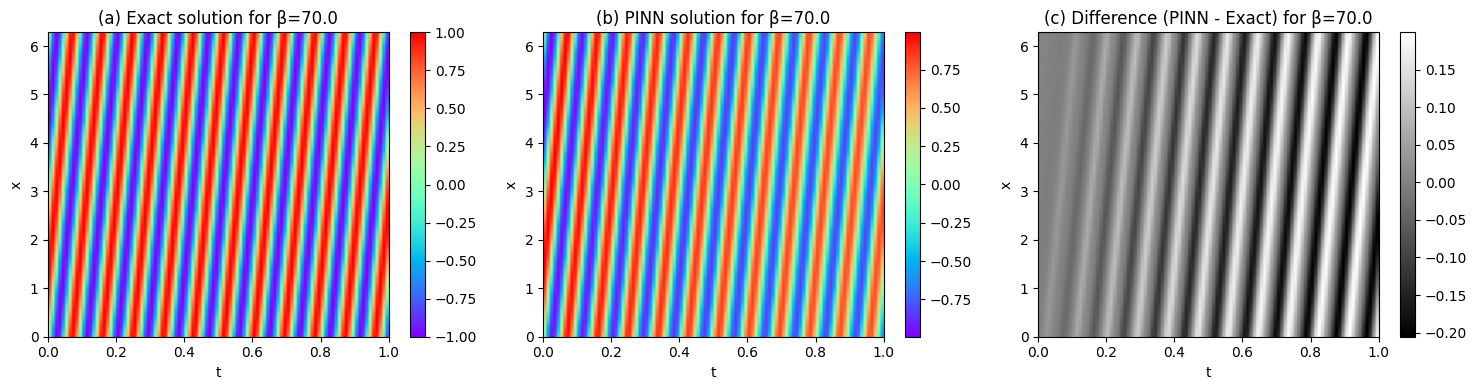

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# (a) Exact solution
c1 = axes[0].imshow(
  U_exact.T,
  extent=[0, t_max, 0, x_max],  # x horizontal, t vertical
  origin="lower",
  aspect="auto",
  cmap="rainbow"
)
axes[0].set_title(f"(a) Exact solution for β={convection_velocity}")
axes[0].set_xlabel("t")
axes[0].set_ylabel("x")
fig.colorbar(c1, ax=axes[0])

# (b) PINN solution
c2 = axes[1].imshow(
    U_pred.T,
    extent=[0, t_max, 0, x_max],
    origin="lower",
    aspect='auto',
    cmap='rainbow'
)
axes[1].set_title(f"(b) PINN solution for β={convection_velocity}")
axes[1].set_xlabel("t")
axes[1].set_ylabel("x")
fig.colorbar(c2, ax=axes[1])

# (c) Difference
c3 = axes[2].imshow(
    U_diff.T,
    extent=[0, t_max, 0, x_max],
    origin="lower",
    aspect='auto',
    cmap='gray'
)
axes[2].set_title(f"(c) Difference (PINN - Exact) for β={convection_velocity}")
axes[2].set_xlabel("t")
axes[2].set_ylabel("x")
fig.colorbar(c3, ax=axes[2])

plt.tight_layout()
plt.show()


In [17]:
torch.save(model,"kmean_pinn.pth")

In [18]:
MAE = np.mean(np.abs(U_diff))
print("Mean Absolute error: ", MAE)

Mean Absolute error:  0.07506109539106408


In [19]:
if(MAE< 0.16):
    torch.save(model, "kmean_pinn.pth")